# Diffusion Models 入門



本ノートブックでは、[Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239)を[公式実装](https://github.com/hojonathanho/diffusion)にもとにPyTorchで実装します。Diffusion Models の仕組みの理解が目的ですので、仕組みを理解するための最低限の実装を提供します。

あらかじめGoogle Driveをマウントし、ランタイムをGPUに変更してください。

In [1]:
!nvidia-smi

Sat May 20 15:37:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## モジュールのインポート

In [2]:
# %cd <このノートブックを保存したディレクトリパス>
%cd /content/drive/MyDrive/diffusion

/content/drive/MyDrive/diffusion


In [3]:
!pip install pytorch-gan-metrics > /dev/null

In [4]:
import matplotlib ;print(matplotlib.__version__) 
import numpy ;print(numpy.__version__) 
import pytorch_gan_metrics ;print(pytorch_gan_metrics.__version__) 
import torch ;print(torch.__version__) 
import torchvision ;print(torchvision.__version__) 
import tqdm ;print(tqdm.__version__) 

3.7.1
1.22.4
0.5.2
2.0.1+cu118
0.15.2+cu118
4.65.0


In [4]:
import copy
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from pytorch_gan_metrics import get_inception_score_and_fid, get_inception_score
from torch import Tensor, nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid, save_image
from tqdm import trange
import json
from torch.utils.tensorboard import SummaryWriter

## U-Netの実装

In [5]:
class TimeEmbedding(nn.Module):
    def __init__(
        self, 
        T: int, 
        d_model: int, 
        temb_dim: int
    ):
        super().__init__()
        assert d_model % 2 == 0
        position = torch.arange(T).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(T, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe
        self.emb = nn.Embedding.from_pretrained(
            pe, freeze=True)

        self.dense0 = nn.Linear(d_model, temb_dim)
        self.dense1 = nn.Linear(temb_dim, temb_dim)

    def forward(self, t):
        temb = self.emb(t)
        temb = F.silu(self.dense0(temb))
        temb = self.dense1(temb)
        return temb
        

class ResidualBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        temb_dim,
        shortcut=True,
        attention=False,
        dropout=0.0
    ):
        super().__init__()
        self.norm1 = nn.GroupNorm(
            num_groups=32, 
            num_channels=in_channels)
        self.conv1 = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=3,
            stride=1,
            padding=1)
        
        self.temb_proj = nn.Linear(
            in_features=temb_dim,
            out_features=out_channels
        )
        self.norm2 = nn.GroupNorm(
            num_groups=32, 
            num_channels=out_channels)
        self.dropout = nn.Dropout2d(p=dropout)
        self.conv2 = nn.Conv2d(
            in_channels=out_channels, 
            out_channels=out_channels, 
            kernel_size=3,
            stride=1,
            padding=1)

        if in_channels != out_channels:
            if shortcut:
                self.shortcut = nn.Conv2d(
                    in_channels=in_channels, 
                    out_channels=out_channels, 
                    kernel_size=3,
                    stride=1,
                    padding=1)
            else:
                raise NotImplementedError()

        if attention:
            self.attn = Attention(d_model=out_channels)
        else:
            self.attn = nn.Identity()
        
    def forward(self, x, temb):
        h = F.silu(self.norm1(x))
        h = self.conv1(h)
        
        # add in timestep embedding
        h = h + self.temb_proj(F.silu(temb))[:, :, None, None]
        h = F.silu(self.norm2(h))
        h = self.dropout(h)
        h = self.conv2(h)
        
        if hasattr(self, 'shortcut'):
            x = self.shortcut(x)
        assert x.shape == h.shape, (x.shape, h.shape)

        h = h + x
        h = self.attn(h)
        return h


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, with_conv=True):
        super().__init__()
        self.with_conv = with_conv
        self.conv = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=3,
            stride=1,
            padding=1)

    def forward(self, x, *dummy):
        B, C, H, W = x.shape
        x = F.interpolate(
            x, 
            scale_factor=2, 
            mode='nearest')
        if self.with_conv:
            x = self.conv(x)
        assert list(x.shape) == [B, C, H * 2, W * 2]
        return x


class DownSample(nn.Module):
    def __init__(self,  in_channels, out_channels, with_conv=True):
        super().__init__()
        self.with_conv = with_conv
        self.conv = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=3,
            stride=2,
            padding=1)
    
    def forward(self, x, *dummy):
        B, C, H, W = x.shape
        if self.with_conv:
            x = self.conv(x)
        else:
            x = F.avg_pool2d(x, kernel_size=2)
        assert list(x.shape) == [B, C, H // 2, W // 2], (x.shape, [B, C, H // 2, W // 2])
        return x


class Attention(nn.Module):
    def __init__(
        self, 
        d_model
    ):
        super().__init__()
        self.norm = nn.GroupNorm(num_groups=32, num_channels=d_model)

        bias = True
        self.q = nn.Conv2d(d_model, d_model, kernel_size=1, stride=1, padding=0, bias=bias)
        self.k = nn.Conv2d(d_model, d_model, kernel_size=1, stride=1, padding=0, bias=bias)
        self.v = nn.Conv2d(d_model, d_model, kernel_size=1, stride=1, padding=0, bias=bias)
        self.proj_out = nn.Conv2d(d_model, d_model, kernel_size=1, stride=1, padding=0, bias=bias)


    def forward(self, x, *dummy):
        B, C, H, W = x.shape
        h = self.norm(x)
        q = self.q(h)
        k = self.k(h)
        v = self.v(h)

        q = q.permute(0, 2, 3, 1).view(B, H * W, C)
        k = k.view(B, C, H * W)
        w = torch.bmm(q, k) * (int(C) ** (-0.5))
        w = F.softmax(w, dim=-1)

        v = v.permute(0, 2, 3, 1).view(B, H * W, C)
        h = torch.bmm(w, v)
        h = h.view(B, H, W, C).permute(0, 3, 1, 2)
        h = self.proj_out(h)
        h = h + x
        return h


class Unet(nn.Module):
    def __init__(
        self,
        T: int,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        temb_dim: int,
        num_res_blocks,
        ch_mult=(1, 2, 4, 8),
        dropout=0.0,
        attn_block_indices=(1,),
        resamp_with_conv=True
    ):
        super().__init__()
        num_resolutions = len(ch_mult)

        self.time_embedding = TimeEmbedding(
            T=T, 
            d_model=hidden_channels,
            temb_dim=temb_dim
        )

        # Downsampling
        self.conv_in = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=hidden_channels, 
            kernel_size=3,
            stride=1,
            padding=1)
        self.down_blocks = nn.ModuleList()
        channels_list = [hidden_channels]
        out_channels_ = hidden_channels
        for i_level in range(num_resolutions):
            # Residual blocks for this resolution
            for i_block in range(num_res_blocks):
                in_channels_ = out_channels_
                out_channels_ = hidden_channels * ch_mult[i_level]
                self.down_blocks.append(
                    ResidualBlock(
                        in_channels=in_channels_, 
                        out_channels=out_channels_, 
                        temb_dim=temb_dim,
                        attention=i_level in attn_block_indices,
                        dropout=dropout
                    )
                )
                channels_list.append(out_channels_)
            if i_level != num_resolutions - 1:
                self.down_blocks.append(
                    DownSample(
                        in_channels=out_channels_,
                        out_channels=out_channels_,
                        with_conv=resamp_with_conv
                    )
                )
                channels_list.append(out_channels_)

        # Middle
        self.mid_blocks = nn.ModuleList([
            ResidualBlock(
                in_channels=out_channels_, 
                out_channels=out_channels_, 
                temb_dim=temb_dim,
                attention=True,
                dropout=dropout
            ),
            ResidualBlock(
                in_channels=out_channels_, 
                out_channels=out_channels_, 
                temb_dim=temb_dim,
                attention=False,
                dropout=dropout
            )
        ])

        # Upsampling
        self.up_blocks = nn.ModuleList()
        for i_level in reversed(range(num_resolutions)):
            # Residual blocks for this resolution
            for i_block in range(num_res_blocks + 1):
                in_channels_ = channels_list.pop() + out_channels_
                out_channels_ = hidden_channels * ch_mult[i_level]
                self.up_blocks.append(
                    ResidualBlock(
                        in_channels=in_channels_, 
                        out_channels=out_channels_,
                        temb_dim=temb_dim,
                        attention=i_level in attn_block_indices,
                        dropout=dropout
                    )
                )
            if i_level != 0:
                self.up_blocks.append(
                    UpSample(
                        in_channels=out_channels_,
                        out_channels=out_channels_,
                        with_conv=resamp_with_conv
                    )
                )
        assert len(channels_list)==0, channels_list

        self.conv_out = nn.Sequential(
            nn.GroupNorm(num_groups=32, num_channels=out_channels_),
            nn.SiLU(),
            nn.Conv2d(
                in_channels=out_channels_, 
                out_channels=out_channels, 
                kernel_size=3,
                stride=1,
                padding=1
            )
        )

    def forward(self, x, t):
        temb = self.time_embedding(t)
        h = self.conv_in(x)
        hs = [h]
        for layer in self.down_blocks:
            h = layer(h, temb)
            hs.append(h)
        for layer in self.mid_blocks:
            h = layer(h, temb)
        for layer in self.up_blocks:
            if isinstance(layer, ResidualBlock):
                h = torch.cat([h, hs.pop()], dim=1)
            h = layer(h, temb)
        h = self.conv_out(h)

        assert len(hs) == 0
        return h


def integration_test():
    batch_size = 2
    model = Unet(
        T=T, 
        in_channels=3, 
        hidden_channels=32,
        out_channels=3, 
        temb_dim=32 * 4,
        ch_mult=(1, 2, 3, 4),
        num_res_blocks=2, 
        dropout=0.1,
        attn_block_indices=(2,),
        resamp_with_conv=True
    )
    x = torch.randn(batch_size, 3, 32, 32)
    t = torch.randint(1000, (batch_size, ))
    y = model(x, t)

In [6]:
def extract(a, t, x_shape):
    """
    Extract some coefficients at specified timesteps,
    then reshape to [batch_size, 1, 1, 1, 1, ...] for broadcasting purposes.
    """
    bs, = t.shape
    assert x_shape[0] == bs
    out = torch.gather(a, dim=0, index=t)
    assert list(out.shape) == [bs]
    return out.view([bs] + ((len(x_shape) - 1) * [1]))


class Diffusion(nn.Module):
    def __init__(
        self,
        model,
        T: int,
        beta_1: float,
        beta_T: float,
        model_var_type: str = 'fixedlarge'
    ):  
        super().__init__()
        self.model = model
        self.T = T
        self.beta_1 = beta_1
        self.beta_T = beta_T
        self.model_var_type = model_var_type

        betas = torch.linspace(beta_1, beta_T, T, dtype=torch.float32)
        self.register_buffer('betas', betas)

        alphas = 1 - self.betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        alphas_cumprod_prev = torch.cat([Tensor([1.]), alphas_cumprod[:-1]])
        sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
        self.register_buffer('sqrt_alphas_cumprod', sqrt_alphas_cumprod)

        sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)
        self.register_buffer('sqrt_one_minus_alphas_cumprod', sqrt_one_minus_alphas_cumprod)

        posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
        self.register_buffer('posterior_variance', posterior_variance)

        posterior_log_variance_clipped = torch.log(torch.cat([posterior_variance[1:2], posterior_variance[1:]]))
        self.register_buffer('posterior_log_variance_clipped', posterior_log_variance_clipped)

        sqrt_recip_alphas_cumprod = torch.sqrt(1. / alphas_cumprod)
        self.register_buffer('sqrt_recip_alphas_cumprod', sqrt_recip_alphas_cumprod)

        sqrt_recipm1_alphas_cumprod = torch.sqrt(1. / alphas_cumprod - 1)
        self.register_buffer('sqrt_recipm1_alphas_cumprod', sqrt_recipm1_alphas_cumprod)

        posterior_mean_coef1 = betas * torch.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod)
        self.register_buffer('posterior_mean_coef1', posterior_mean_coef1)

        posterior_mean_coef2 = (1. - alphas_cumprod_prev) * torch.sqrt(alphas) / (1. - alphas_cumprod)
        self.register_buffer('posterior_mean_coef2', posterior_mean_coef2)

    def forward(self, x_0, eps_true, t):
        """
        Algorithm 1.

        x_0 shape (B, C, H, W)
        t shape (B, )
        """
        x_t = extract(self.sqrt_alphas_cumprod, t, x_0.shape) * x_0 \
        + extract(self.sqrt_one_minus_alphas_cumprod, t, x_0.shape) * eps_true

        eps_pred = self.model(x_t, t)
        loss = F.mse_loss(eps_pred, eps_true, reduction='mean')
        return {
            'loss': loss,
            'eps': eps_pred
        }
    
    def p_sample(self, x_t, i_time):
        """
        x_t : shape (B, C, H, W)
        i_time : int
        """
        t = x_t.new_ones((x_t.shape[0], ), dtype=torch.long) * i_time
        mean, _, log_var, pred_xstart = self._p_mean_variance(x_t=x_t, t=t)
        # no noise when t == 0
        if i_time > 0:
            z = torch.randn_like(x_t)
        else:
            z = 0
        return (mean + torch.exp(0.5 * log_var) * z, pred_xstart)

    def p_sample_loop(self, x_T):
        """
        Algorithm 2.

        x_T shape (B, C, H, W)
        """
        x_t = x_T
        for i_time in reversed(range(self.T)):
            x_t, _ = self.p_sample(x_t, i_time)
        x_0 = x_t
        return torch.clip(x_0, -1, 1)

    def _p_mean_variance(self, x_t, t, clip_denoised=True):
        """
        mu_theta(x_t, t), sigma_t を求める関数.
        """
        model_variance, model_log_variance = {
            # for fixedlarge, we set the initial (log-)variance like so to get a better decoder log likelihood
            'fixedlarge': (self.betas, torch.log(torch.cat([self.posterior_variance[1:2], self.betas[1:]]))),
            'fixedsmall': (self.posterior_variance, self.posterior_log_variance_clipped),
        }[self.model_var_type]

        model_variance = extract(model_variance, t, x_t.shape)
        model_log_variance = extract(model_log_variance, t, x_t.shape)

        model_output = self.model(x_t, t)
        _maybe_clip = lambda x_: torch.clip(x_, -1., 1.) if clip_denoised else x_
        pred_xstart = _maybe_clip(self._predict_xstart_from_eps(x_t=x_t, t=t, eps=model_output))
        model_mean, _, _ = self._q_posterior_mean_variance(x_start=pred_xstart, x_t=x_t, t=t)

        return model_mean, model_variance, model_log_variance, pred_xstart

    def _q_posterior_mean_variance(self, x_start, x_t, t):
        """
        q(x_{t-1} | x_t, x_0)の平均と分散を求める関数.
        """
        assert x_start.size() == x_t.size()
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_start +
            extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract(self.posterior_log_variance_clipped, t, x_t.shape)
        assert (posterior_mean.shape[0] == posterior_variance.shape[0] == posterior_log_variance_clipped.shape[0] ==
                x_start.shape[0])
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def _predict_xstart_from_eps(self, x_t, t, eps):
        """
        x_t と eps から x_0 を求める関数.
        """
        assert x_t.size() == eps.size(), (x_t.size(), eps.size())
        return extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t \
            - extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * eps

## Datasetの実装

In [7]:
def infinite_loop(dataloader):
    while True:
        for x, y in iter(dataloader):
            yield x


DATASETS = {
  "cifar10": datasets.CIFAR10,
  "celeba": datasets.CelebA,
  "flowers102": datasets.Flowers102
}


def get_dataset(name, root='./data', split='train', download=True, transform=None):
    """Instantiates a data set and sets the random seed.
    """
    if name not in DATASETS:
        raise ValueError("Dataset {} is not available.".format(name))

    if split not in ['train', 'val', 'test']:
        raise ValueError("Split {} is not available.".format(split))

    kwargs = {
        'root': root,
        'download': download,  
    }

    if transform is not None:
        kwargs['transform'] = transform

    if name == 'cifar10':
        if split == 'train':
            split = True
        else:
            split = False
        kwargs['train'] = split

    elif name == 'celeba':
        if split == 'val':
            split = 'valid'
        kwargs['split'] = split

    elif name == 'flowers102':
        kwargs['split'] = split

    else:
        raise ValueError("Dataset {} is not available.".format(name))

    return DATASETS[name](**kwargs)

## 指数移動平均の実装

In [8]:
def ema(source, target, decay):
    source_dict = source.state_dict()
    target_dict = target.state_dict()
    for key in source_dict.keys():
        target_dict[key].data.copy_(
            target_dict[key].data * decay +
            source_dict[key].data * (1 - decay))   

## 評価関数の実装

In [9]:
def evaluate(diffusion, model, device):
    num_images = 64
    batch_size = 64
    img_size = 64
    fid_use_torch = False

    model.eval()
    with torch.no_grad():
        images = []
        desc = "generating images"
        for i in trange(0, num_images, batch_size, desc=desc):
            batch_size = min(batch_size, num_images - i)
            x_T = torch.randn((batch_size, 3, img_size, img_size))
            batch_images = diffusion.p_sample_loop(x_T.to(device)).cpu()
            images.append((batch_images + 1) / 2)
        images = torch.cat(images, dim=0)

    model.train()
    FID = -1
    # FIDを利用する場合は cifar10.train.npz を用意してコメントアウトする
    # (IS, IS_std), FID = get_inception_score_and_fid(
    #     images=images, 
    #     fid_stats_path='cifar10.train.npz', 
    #     splits = 10,
    #     use_torch=fid_use_torch, 
    # )
    IS, IS_std = get_inception_score(
    images=images)
    return (IS, IS_std), FID, images

## 学習ループの実装

In [10]:
T = 1000
beta_1 = 1e-4
beta_T = 0.02
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
lr = 2e-4
ema_decay = 0.9999
n_step = 40_000
num_workers = 4
train_batch_size = 64
save_step = 4000
eval_step = 4000
sample_step = 4000
log_dir = './log'
grad_clip = 1.
img_size = 64
sample_size = 16


transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
train_dataset = get_dataset(
    name='flowers102',
    root='./data', 
    split='test', 
    download=True, 
    transform=transform
)
train_loader = DataLoader(
    train_dataset, 
    batch_size=train_batch_size, 
    shuffle=True,
    num_workers=num_workers, 
    pin_memory=True,
    drop_last=True)

train_loop_loader = infinite_loop(train_loader)

net_model = Unet(
    T=T, 
    in_channels=3, 
    hidden_channels=32,
    out_channels=3, 
    temb_dim=32 * 4,
    ch_mult=(1, 2, 3, 4),
    num_res_blocks=2, 
    dropout=0.1,
    attn_block_indices=(2,),
    resamp_with_conv=True
)
ema_model = copy.deepcopy(net_model)

diffusion = Diffusion(
    model=net_model,
    T=T,
    beta_1=beta_1,
    beta_T=beta_T
).to(device)

ema_diffusion = Diffusion(
    model=ema_model,
    T=T,
    beta_1=beta_1,
    beta_T=beta_T
).to(device)

optimizer = torch.optim.Adam(net_model.parameters(), lr=lr)

os.makedirs(os.path.join(log_dir, 'sample'), exist_ok=True)


# show model size
model_size = 0
for param in net_model.parameters():
    model_size += param.data.nelement()
print('Model params: %.2f M' % (model_size / 1024 / 1024))

Model params: 6.53 M


In [11]:
x_T = torch.randn(sample_size, 3, img_size, img_size)
x_T = x_T.to(device)

次のセルを実行すると学習が始まります。4時間程度かかります。学習済みモデルを使用する場合は飛ばしてください。

In [12]:
grid = (make_grid(next(iter(train_loader))[0][:sample_size]) + 1) / 2
writer = SummaryWriter(log_dir)
path = os.path.join(
    log_dir, 'sample', 'real_sample.png')
save_image(grid, path)
writer.add_image('real_sample', grid)
writer.flush()

ema_model.eval()
with torch.no_grad():
    x_0 = ema_diffusion.p_sample_loop(x_T)
    grid = (make_grid(x_0) + 1) / 2
    path = os.path.join(
        log_dir, 'sample', '%d.png' % 0)
    save_image(grid, path)
    writer.add_image('sample', grid, 0)
    writer.flush()
ema_model.train()


with trange(n_step, dynamic_ncols=True) as pbar:
    for step in pbar:
        step_ = step + 1
        data = next(train_loop_loader)
        x_0 = data.to(device)

        optimizer.zero_grad()
        
        t = torch.randint(T, size=(x_0.shape[0], ), device=device)
        noise = torch.randn_like(x_0, device=device)
        out = diffusion(x_0, noise, t)
        loss = out['loss']

        loss.backward()
        nn.utils.clip_grad_norm_(
                    net_model.parameters(), grad_clip)
        optimizer.step()

        ema(net_model, ema_model, ema_decay)

        pbar.set_postfix(loss='%.3f' % loss.item())

        if sample_step > 0 and step_ % sample_step == 0:
            ema_model.eval()
            with torch.no_grad():
                x_0 = ema_diffusion.p_sample_loop(x_T)
                grid = (make_grid(x_0) + 1) / 2
                path = os.path.join(
                    log_dir, 'sample', '%d.png' % step_)
                save_image(grid, path)
                writer.add_image('sample', grid, step_)
            ema_model.train()

        if save_step > 0 and step_ % save_step == 0:
            ckpt = {
                'net_model': net_model.state_dict(),
                'ema_model': ema_model.state_dict(),
                'optim': optimizer.state_dict(),
                'step': step_
            }
            torch.save(ckpt, os.path.join(log_dir, 'ckpt.pt'))

        if eval_step > 0 and step_ % eval_step == 0:
            (net_IS, net_IS_std), net_FID, _ = evaluate(diffusion, net_model, device=device)
            (ema_IS, ema_IS_std), ema_FID, _ = evaluate(ema_diffusion, ema_model, device=device)
            metrics = {
                'IS': net_IS,
                'IS_std': net_IS_std,
                'FID': net_FID,
                'IS_EMA': ema_IS,
                'IS_std_EMA': ema_IS_std,
                'FID_EMA': ema_FID
            }
            pbar.write(
                "%d/%d " % (step, n_step) +
                ", ".join('%s:%.3f' % (k, v) for k, v in metrics.items()))
            for name, value in metrics.items():
                writer.add_scalar(name, value, step_)
            writer.flush()
            with open(os.path.join(log_dir, 'eval.txt'), 'a') as f:
                metrics['step'] = step_
                f.write(json.dumps(metrics) + "\n")
writer.close()

generating images: 100%|██████████| 1/1 [00:37<00:00, 37.31s/it]
Downloading: "https://github.com/w86763777/pytorch-gan-metrics/releases/download/v0.1.0/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth

  0%|          | 0.00/91.2M [00:00<?, ?B/s]
  2%|▏         | 1.50M/91.2M [00:00<00:06, 15.3MB/s]
  5%|▌         | 4.78M/91.2M [00:00<00:04, 22.6MB/s]
 12%|█▏        | 11.3M/91.2M [00:00<00:02, 36.6MB/s]
 19%|█▊        | 17.1M/91.2M [00:00<00:01, 44.8MB/s]
 24%|██▍       | 22.1M/91.2M [00:00<00:01, 47.2MB/s]
 30%|██▉       | 27.1M/91.2M [00:00<00:01, 49.0MB/s]
 35%|███▍      | 31.8M/91.2M [00:00<00:01, 44.8MB/s]
 40%|████      | 36.7M/91.2M [00:00<00:01, 46.6MB/s]
 45%|████▌     | 41.2M/91.2M [00:01<00:01, 45.2MB/s]
 52%|█████▏    | 47.7M/91.2M [00:01<00:00, 50.1MB/s]
 58%|█████▊    | 52.5M/91.2M [00:01<00:00, 46.6MB/s]
 64%|██████▎   | 57.9M/91.2M [00:01<00:00, 49.3MB/s]
 69%|██████▉   | 63.1M/91.2M [00:01<00:00, 50.6MB/s]


3999/40000 IS:2.601, IS_std:0.332, FID:-1.000, IS_EMA:1.312, IS_std_EMA:0.076, FID_EMA:-1.000


generating images: 100%|██████████| 1/1 [00:37<00:00, 37.29s/it]

 20%|██        | 8001/40000 [41:05<174:48:45, 19.67s/it, loss=0.015]

7999/40000 IS:2.377, IS_std:0.430, FID:-1.000, IS_EMA:1.197, IS_std_EMA:0.054, FID_EMA:-1.000


generating images: 100%|██████████| 1/1 [00:37<00:00, 37.32s/it]

 30%|███       | 12000/40000 [55:22<216:27:26, 27.83s/it, loss=0.020]

11999/40000 IS:2.246, IS_std:0.385, FID:-1.000, IS_EMA:1.338, IS_std_EMA:0.087, FID_EMA:-1.000


generating images: 100%|██████████| 1/1 [00:37<00:00, 37.28s/it]

 40%|████      | 16001/40000 [1:09:32<130:08:40, 19.52s/it, loss=0.041]

15999/40000 IS:2.526, IS_std:0.422, FID:-1.000, IS_EMA:1.351, IS_std_EMA:0.171, FID_EMA:-1.000


generating images: 100%|██████████| 1/1 [00:37<00:00, 37.34s/it]

 50%|█████     | 20001/40000 [1:23:48<109:37:55, 19.73s/it, loss=0.017]

19999/40000 IS:2.461, IS_std:0.383, FID:-1.000, IS_EMA:1.281, IS_std_EMA:0.051, FID_EMA:-1.000


generating images: 100%|██████████| 1/1 [00:37<00:00, 37.28s/it]

 60%|██████    | 24000/40000 [1:38:07<123:15:07, 27.73s/it, loss=0.021]

23999/40000 IS:2.376, IS_std:0.277, FID:-1.000, IS_EMA:1.476, IS_std_EMA:0.102, FID_EMA:-1.000


generating images: 100%|██████████| 1/1 [00:37<00:00, 37.33s/it]

 70%|███████   | 28001/40000 [1:52:36<65:15:13, 19.58s/it, loss=0.038]

27999/40000 IS:2.026, IS_std:0.185, FID:-1.000, IS_EMA:1.599, IS_std_EMA:0.127, FID_EMA:-1.000


generating images: 100%|██████████| 1/1 [00:37<00:00, 37.27s/it]

 80%|████████  | 32001/40000 [2:07:01<43:26:18, 19.55s/it, loss=0.043]

31999/40000 IS:2.305, IS_std:0.388, FID:-1.000, IS_EMA:1.713, IS_std_EMA:0.122, FID_EMA:-1.000


generating images: 100%|██████████| 1/1 [00:37<00:00, 37.33s/it]

 90%|█████████ | 36000/40000 [2:21:27<30:54:27, 27.82s/it, loss=0.021]

35999/40000 IS:2.339, IS_std:0.303, FID:-1.000, IS_EMA:1.780, IS_std_EMA:0.120, FID_EMA:-1.000


generating images: 100%|██████████| 1/1 [00:37<00:00, 37.29s/it]

100%|██████████| 40000/40000 [2:35:44<00:00,  4.28it/s, loss=0.019]

39999/40000 IS:2.387, IS_std:0.379, FID:-1.000, IS_EMA:2.068, IS_std_EMA:0.370, FID_EMA:-1.000


## 学習済みモデルによる推論

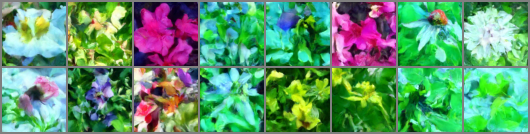

In [13]:
from IPython.display import display


ema_model = Unet(
    T=T, 
    in_channels=3, 
    hidden_channels=32,
    out_channels=3, 
    temb_dim=32 * 4,
    ch_mult=(1, 2, 3, 4),
    num_res_blocks=2, 
    dropout=0.1,
    attn_block_indices=(2,),
    resamp_with_conv=True
)
ema_diffusion = Diffusion(
    model=ema_model,
    T=T,
    beta_1=beta_1,
    beta_T=beta_T
).to(device)

# load model
ckpt = torch.load(os.path.join(log_dir, 'ckpt.pt'))
ema_model.load_state_dict(ckpt['ema_model'])

ema_model.eval()
with torch.no_grad():
    x_0 = ema_diffusion.p_sample_loop(x_T)
grid = (make_grid(x_0) + 1) / 2

img = to_pil_image(grid)
display(img)

## 時間ステップごとの推論

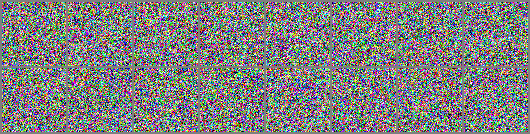

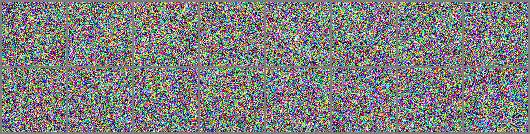

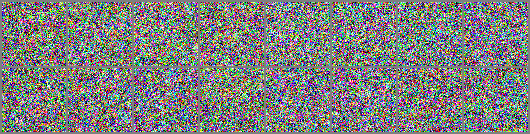

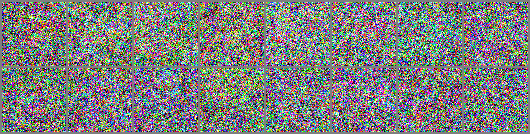

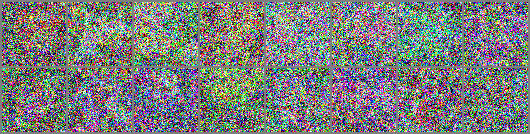

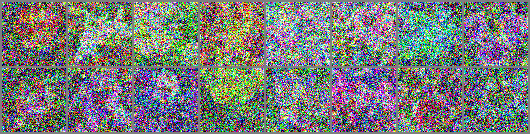

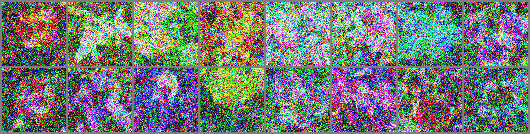

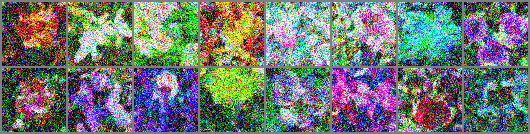

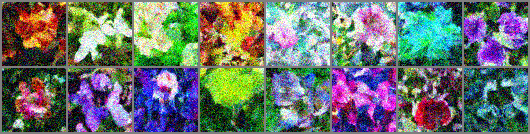

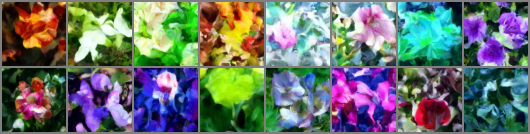

In [14]:
x_t = x_T
ema_model.eval()

grid = (make_grid(torch.clip(x_t, -1, 1)) + 1) / 2
path = os.path.join(
    log_dir, 'sample', 'timestep=%d.png' % 1000)
save_image(grid, path)

for i_time in reversed(range(T)):
    with torch.no_grad():
        x_t, _ = ema_diffusion.p_sample(x_t, i_time)
    if i_time % 100 == 0:
        grid = (make_grid(torch.clip(x_t, -1, 1)) + 1) / 2
        path = os.path.join(
            log_dir, 'sample', 'timestep=%d.png' % i_time)
        save_image(grid, path)
        img = to_pil_image(grid)
        display(img)